Objective:
* Perform basic data preprocessing in Python
* Model a classification task using Scikit Learn and Snap ML Python APIs
* Train Supoort Vector Machine and Decision Tree models using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models

Dataset Reference: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud



In [7]:
!pip install scikit-learn
!pip install snapml

In [8]:
#Importing the libraries required for this task
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#this is to ensure the visualization of the plot if generated inside the notebook
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

Dataset Analysis


In [9]:
raw_data=pd.read_csv('creditcard.csv')
#fetching dimensions of the data
raw_data.shape

(284807, 31)

In [10]:
#display first rows in dataset
raw_data[0:1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case we will inflate the original one 10 times.

In [11]:
n_replicas = 10

#inflate original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print(big_raw_data.shape)

(2848070, 31)


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.


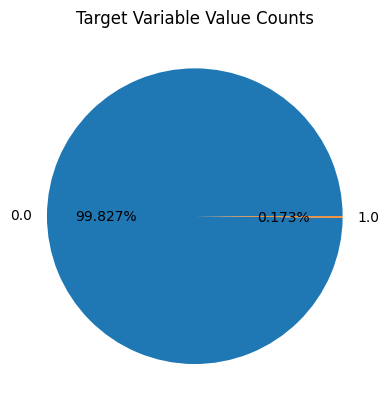

In [12]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

From the pie chart above you can understand that there are two distinct classes, 0 and 1 stating whethere the credit card is fraudalent or legitimate. We can also see that the dataset is highly unbalanced, the target variable(Class) is not represented equally. Thereore we need to make the model pay more attendtion to samples in the minority class.

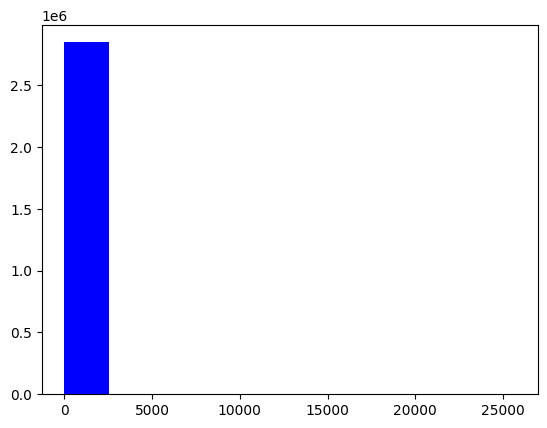

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [13]:
plt.hist(big_raw_data.Amount.values, 10, histtype='bar', facecolor='b')
plt.show()

print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

# Data Preprocessing


In [14]:
# data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence

#standardize features by removing the mean and scaling to unit variance 
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])

data_matrix = big_raw_data.values

X = data_matrix[:, 1:30] #1-29
y = data_matrix[:, 30] #last column

#data normalization
X = normalize(X, norm="l1") #normalizes in l1 from which specifies that the normalization should be done using the l1 norm which scales the values so that the sum of absolute values in each row equals 1

print('X Shape:', X.shape, 'y Shape: ', y.shape)



X Shape: (2848070, 29) y Shape:  (2848070,)


# Data Train/Test Split


stratify=y:

    stratify=y ensures that the split preserves the proportion of classes in y across the training and test sets.
    This is especially important in cases of imbalanced datasets, where certain classes might be underrepresented.
    If y contains, for example, 70% of one class and 30% of another, the stratification will ensure that the training and test sets maintain the same ratio.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


# Decision Tree Classifier


In [16]:
w_train = compute_sample_weight('balanced', y_train)

from sklearn.tree import DecisionTreeClassifier

sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  33.88261


Decision Tree Classifier with SnapML


In [18]:
from snapml import DecisionTreeClassifier

snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time() - t0
print("[SnapMl-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[SnapMl-Learn] Training time (s):  2.96791


# Evaluating the Scikit Learn and Snap Ml Decision Tree Classifier

In [22]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 1.13x 
[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966
